In [1]:
from functools import partial

from ariel_experiments.characterize.canonical.core.toolkit import (
    CanonicalToolKit as ctk,
)
from ariel_experiments.characterize.individual import analyze_neighbourhood
from ariel_experiments.utils.initialize import (
    generate_random_population_parallel,
)


from ariel_experiments.characterize.individual import analyze_canonical_string
from ariel_experiments.characterize.population import (
    derive_matrix_numerics,
    matrix_derive_neighbourhood,
    get_full_analyzed_population,
)
from ariel_experiments.gui_vis.gui import (
    IndividualVisualizer,
)
from ariel_experiments.gui_vis.gui_simple import (
    SimpleNavigator,
)

from ariel_experiments.gui_vis.visualize_tree import visualize_tree_from_graph

import seaborn as sns
import numpy as np
import plotly.graph_objects as go

from ariel_experiments.gui_vis.view_mujoco import view

import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from rich.console import Console
console = Console()

In [3]:
def plot_matrix_distribution(
    matrix: np.ndarray,
    triangle: str = "upper",
    include_diagonal: bool = False,
    cmap: str = "viridis",
    bins: int = 190,
    figsize: tuple[int, int] = (14, 6),
    title_prefix: str = ""
):
    """Plot matrix heatmap and value distribution side by side."""
    
    # Extract triangle values
    k_offset = 1 if not include_diagonal else 0
    
    if triangle.lower() == "upper":
        values = matrix[np.triu_indices_from(matrix, k=k_offset)]
        mask = np.tril(np.ones_like(matrix, dtype=bool), k=k_offset-1)
        triangle_name = "Upper"
    elif triangle.lower() == "lower":
        values = matrix[np.tril_indices_from(matrix, k=-k_offset)]
        mask = np.triu(np.ones_like(matrix, dtype=bool), k=-k_offset+1)
        triangle_name = "Lower"
    else:
        raise ValueError("triangle must be 'upper' or 'lower'")
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot heatmap
    sns.heatmap(
        matrix,
        mask=mask,
        ax=axes[0],
        cmap=cmap,
        square=True,
        cbar_kws={'label': 'Value'}
    )
    diag_text = "with" if include_diagonal else "without"
    axes[0].set_title(f'{title_prefix}{triangle_name} Triangle Heatmap\n({diag_text} diagonal)')
    axes[1].hist(values, bins=bins, alpha=0.7, edgecolor='black', color='steelblue')
    axes[1].axvline(np.mean(values), color='black', linestyle='--', 
                    linewidth=1, label=f'Mean: {np.mean(values):.3f}')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title(f'{title_prefix}Value Distribution (n={len(values)})')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Add statistics text
    stats_text = (
        f'Min: {np.min(values):.3f}\n'
        f'Max: {np.max(values):.3f}\n'
        f'Std: {np.std(values):.3f}'
    )
    axes[1].text(0.98, 0.97, stats_text,
                transform=axes[1].transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=9)
    
    plt.tight_layout()
    return fig, axes


In [4]:
population_size = 1_000

In [5]:
population = generate_random_population_parallel(population_size)

Output()

In [6]:
radius_strategy = ctk.RadiusStrategy.TREE_GLOBAL
max_tree_radius = 3

missing_data_mode = ctk.MissingDataMode.SKIP_RADIUS

tanimoto_mode = ctk.TanimotoMode.COUNTS
weighting_mode = ctk.WeightingMode.LINEAR

softmax_beta = 1
power_mean_p = 1


similarity_config = ctk.SimilarityConfig(
    radius_strategy=radius_strategy,
    weighting_mode=weighting_mode,
    max_tree_radius=max_tree_radius,
    missing_data_mode=missing_data_mode,
    tanimoto_mode=tanimoto_mode,
    softmax_beta=softmax_beta,
    power_mean_p=power_mean_p,
)

In [7]:
analyzed_population = get_full_analyzed_population(
    population,
    analyzers=[
        partial(analyze_neighbourhood, config=similarity_config),
    ],
    derivers=[],
    n_jobs=-1, # fastest
)
matrix_result = matrix_derive_neighbourhood(
    analyzed_population.raw,
    config=similarity_config,
    symmetric=True,
    n_jobs=-1 # fastest
)

Output()

Output()

Computing neighbourhood:   0%|          | 0/100 [00:00<?, ?batch/s]

In [8]:
analyzed_population.derived["neighbourhood"]["similarity_matrix"] = matrix_result["similarity_matrix"]
matrix_stats = derive_matrix_numerics(
    analyzed_population.derived,
    key="neighbourhood"
)
analyzed_population.derived["neighbourhood"].update(matrix_stats)


In [9]:
analyzed_population.show_tree()

AnalyzedPopulation — props=1 derived_keys=1
├── raw
│   └── neighbourhood: len=1000, type=dict
└── derived
    └── neighbourhood
        └── similarity_matrix

In [10]:
matrix = analyzed_population.derived["neighbourhood"]["similarity_matrix"]['full']
upper_triu_idx = np.triu_indices_from(matrix, k=1)
vals = matrix[upper_triu_idx]

-----

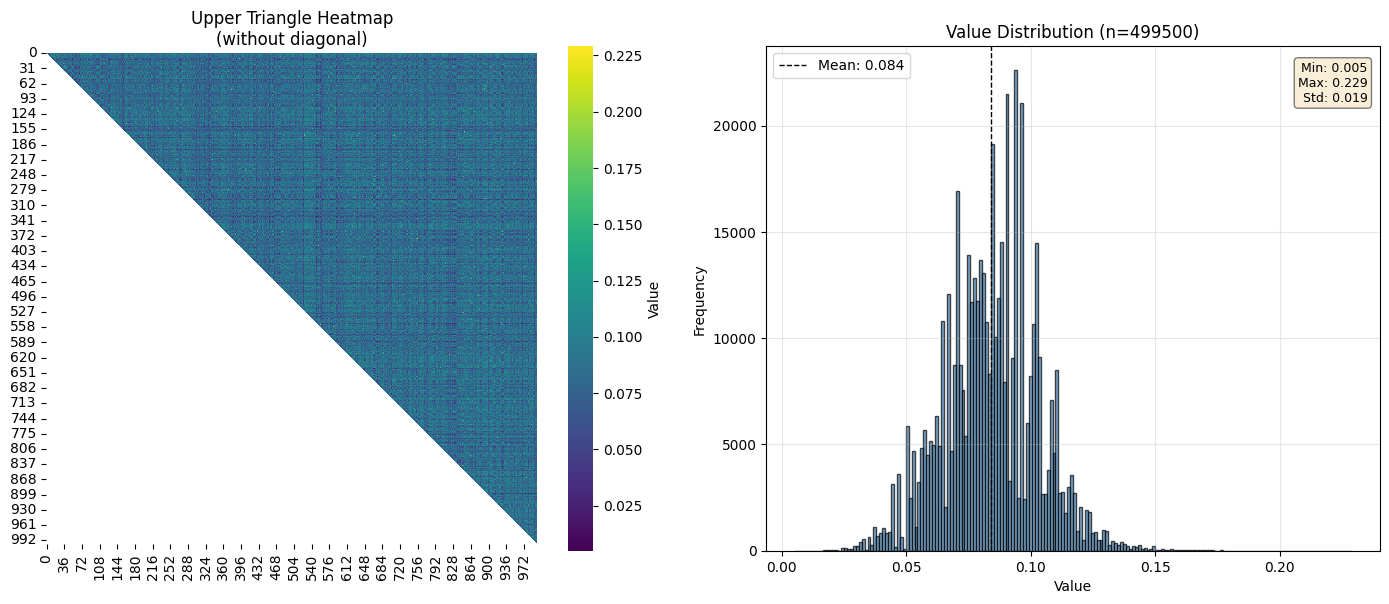

In [11]:
fig, axes = plot_matrix_distribution(matrix)
plt.show()

##### Highest similarity

In [12]:
N = 20
if vals.size == 0:
    top = []
else:
    k = min(N, vals.size)
    sel = np.argpartition(-vals, k-1)[:k]               # top k (unsorted)
    sel = sel[np.argsort(-vals[sel])]                   # sorted desc
    rows = upper_triu_idx[0][sel]
    cols = upper_triu_idx[1][sel]
    top = list(zip(rows.tolist(), cols.tolist(), vals[sel].tolist()))

# top is a list of (row, col, value) tuples sorted by value desc
console.print(top)

iterator = 0

[
    (200, 944, 0.2290000021457672),
    (100, 767, 0.21899999678134918),
    (388, 765, 0.2070000022649765),
    (159, 851, 0.2070000022649765),
    (168, 449, 0.20399999618530273),
    (93, 911, 0.20399999618530273),
    (841, 919, 0.20399999618530273),
    (122, 495, 0.20399999618530273),
    (491, 727, 0.2029999941587448),
    (338, 791, 0.20100000500679016),
    (423, 693, 0.20000000298023224),
    (367, 508, 0.19900000095367432),
    (600, 779, 0.19699999690055847),
    (153, 516, 0.19599999487400055),
    (74, 377, 0.1940000057220459),
    (753, 991, 0.19300000369548798),
    (152, 477, 0.19200000166893005),
    (386, 676, 0.19200000166893005),
    (522, 583, 0.19200000166893005),
    (493, 880, 0.19099999964237213)
]

keep pressing this notebook cell to iterate over the robots

viewing: 200 with similarity [0.2290000021457672]

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen
Dropped Escape call with ulEscapeCode : 0x03007703


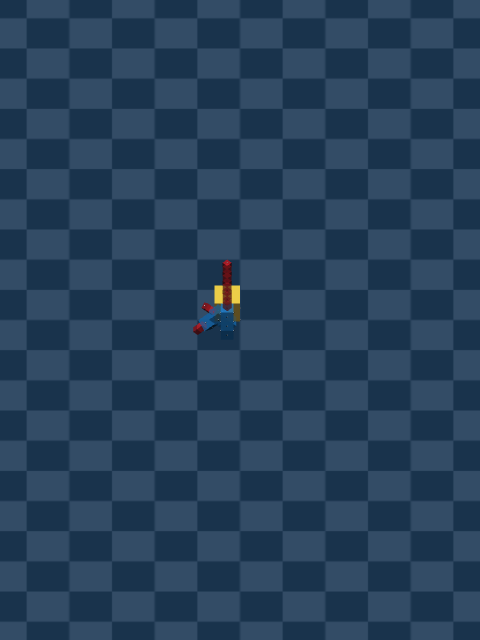

viewing: 200 with similarity [0.2290000021457672]

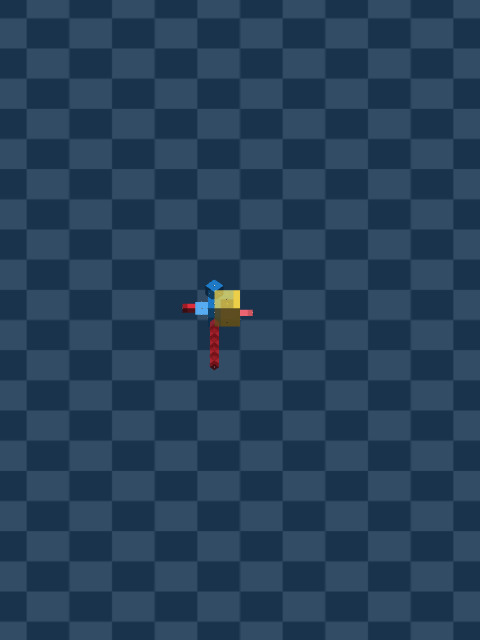

SimilarityResults(
    neighbourhood_dicts=(
        {
            0: ['C', 'B', 'B', 'B', 'B', 'H', 'H', 'H', 'H', 'H', 'B', 'H', 'B', 'H'],
            1: [
                'C[r(B1)]',
                'C[r(B1[t(B)]B1)]',
                'BB1[l(B)]',
                'B[l(BB)]',
                'BBH3',
                'BH3H',
                'HHH2',
                'HH2H2',
                'HH2H2',
                'HH2',
                'B[r(B[b(B1)]H1)]',
                'BH1',
                'B[r(B1H3)]',
                'BH3'
            ],
            2: [
                'C[r(B1[t(B)]B1)]',
                'C[r(B1[t(B[r(B1)]H3)]B1[l(B)])]',
                'C[r(B1[t(B)]B1[l(BB)])]',
                'BB1[l(BBH3)]',
                'B[l(BBH3H)]',
                'BBH3HH2',
                'BH3HH2H2',
                'HHH2H2H2',
                'HH2H2H2',
                'HH2H2',
                'C[r(B1[t(B[r(B1H3)]H3)]B1)]',
                'B[r(B[b(B1)]H1)]',
                'B[r(B[b(B1H1)]H1)]',
                'B[r(B1H3)]'
            ],
            3: [
                'C[r(B1[t(B[r(B1)]H3)]B1[l(B)])]',
                'C[r(B1[t(B[r(B1H3)]H3)]B1[l(BB)])]',
                'C[r(B1[t(B[r(B1)]H3)]B1[l(BBH3)])]',
                'C[r(B1[t(B)]B1[l(BBH3H)])]',
                'BB1[l(BBH3HH2)]',
                'B[l(BBH3HH2H2)]',
                'BBH3HH2H2H2',
                'BH3HH2H2H2',
                'HHH2H2H2',
                'HH2H2H2',
                'C[r(B1[t(B[r(B1H3)]H3)]B1[l(B)])]',
                'C[r(B1[t(B[r(B1H3)]H3)]B1)]',
                'C[r(B1[t(B[r(B1H3)]H3)]B1)]',
                'B[r(B[b(B1H1)]H1)]'
            ]
        },
        {
            0: ['C', 'B', 'B', 'B', 'B', 'H', 'H', 'H', 'H', 'H', 'B', 'B', 'H', 'B', 'H'],
            1: [
                'C[l(B)f(H3)]',
                'C[r(B[l(B)])]',
                'B[l(B[l(B)t(B1)])]',
                'B[l(B[r(B1)]B)]',
                'BB[t(B)]H3',
                'BH3H',
                'HHH2',
                'HH2H2',
                'HH2H2',
                'HH2',
                'B[r(B)]',
                'B[l(B1H1)]',
                'BH1',
                'B[r(B1)]',
                'C[r(H3)]'
            ],
            2: [
                'C[b(B[l(B)])l(H3)]',
                'C[r(B[l(B[l(B)t(B1)])])b(H3)]',
                'C[r(B[l(B[t(B1)l(B[r(B1)]B)])])]',
                'B[l(B[t(B1)l(B[r(B1H1)]B[t(B)]H3)])]',
                'B[l(B[r(B1)]B[t(B)]H3H)]',
                'BB[t(B)]H3HH2',
                'BH3HH2H2',
                'HHH2H2H2',
                'HH2H2H2',
                'HH2H2',
                'BB[t(B)]H3',
                'B[l(B[r(B1H1)]B)]',
                'B[l(B1H1)]',
                'B[l(B[l(B)t(B1)])]',
                'C[b(B)l(H3)]'
            ],
            3: [
                'C[r(B[l(B[l(B)t(B1)])])b(H3)]',
                'C[r(B[l(B[t(B1)l(B[r(B1)]B)])])b(H3)]',
                'C[r(B[l(B[t(B1)l(B[r(B1H1)]B[t(B)]H3)])])b(H3)]',
                'C[r(B[l(B[t(B1)l(B[r(B1H1)]B[t(B)]H3H)])])]',
                'B[l(B[t(B1)l(B[r(B1H1)]B[t(B)]H3HH2)])]',
                'B[l(B[r(B1)]B[t(B)]H3HH2H2)]',
                'BB[t(B)]H3HH2H2H2',
                'BH3HH2H2H2',
                'HHH2H2H2',
                'HH2H2H2',
                'B[l(B[r(B1)]B[t(B)]H3H)]',
                'B[l(B[t(B1)l(B[r(B1H1)]B[t(B)]H3)])]',
                'B[l(B[r(B1H1)]B)]',
                'C[r(B[l(B[t(B1)l(B[r(B1)]B)])])]',
                'C[r(B[l(B)])b(H3)]'
            ]
        }
    ),
    similarity_value=0.23966109253065776,
    tanimoto_dict={0: 0.9333333333333333, 1: 0.2608695652173913, 2: 0.16, 3: 0.11538461538461539},
    selected_radii=[0, 1, 2, 3],
    obtained_weights=[1.0, 2.0, 3.0, 4.0]
)

In [13]:
node1 = ctk.from_graph(population[top[int(0 + iterator)][0]]).canonicalize()
node2 = ctk.from_graph(population[top[int(0 + iterator)][1]]).canonicalize()

console.print(f"viewing: {top[int(iterator)][0]} with similarity {[top[int(iterator)][2]]}")
view(node1.to_graph())
console.print(f"viewing: {top[int(iterator)][0]} with similarity {[top[int(iterator)][2]]}")
view(node2.to_graph())

results = ctk.calculate_similarity(node1, node2, config=similarity_config, return_all=True)
console.print(results)

iterator += 1 % N

##### Lowest similarity

In [14]:
N = 20

if vals.size == 0:
    bottom = []
else:
    k = min(N, vals.size)
    sel = np.argpartition(vals, k-1)[:k]                # bottom k (unsorted)
    sel = sel[np.argsort(vals[sel])]                    # sorted asc
    rows = upper_triu_idx[0][sel]
    cols = upper_triu_idx[1][sel]
    bottom = list(zip(rows.tolist(), cols.tolist(), vals[sel].tolist()))

# bottom is a list of (row, col, value) tuples sorted by value asc (lowest first)
console.print(bottom)
iterator = 0

[
    (298, 897, 0.004999999888241291),
    (550, 897, 0.010999999940395355),
    (172, 897, 0.010999999940395355),
    (149, 298, 0.010999999940395355),
    (298, 801, 0.012000000104308128),
    (454, 897, 0.014000000432133675),
    (298, 994, 0.014000000432133675),
    (237, 897, 0.014000000432133675),
    (298, 523, 0.014000000432133675),
    (298, 842, 0.014999999664723873),
    (712, 897, 0.014999999664723873),
    (298, 760, 0.014999999664723873),
    (793, 897, 0.014999999664723873),
    (558, 897, 0.01600000075995922),
    (485, 897, 0.01600000075995922),
    (850, 897, 0.01600000075995922),
    (298, 332, 0.01600000075995922),
    (38, 897, 0.01600000075995922),
    (149, 172, 0.017000000923871994),
    (257, 897, 0.017000000923871994)
]

viewing: 298 with similarity [0.004999999888241291]

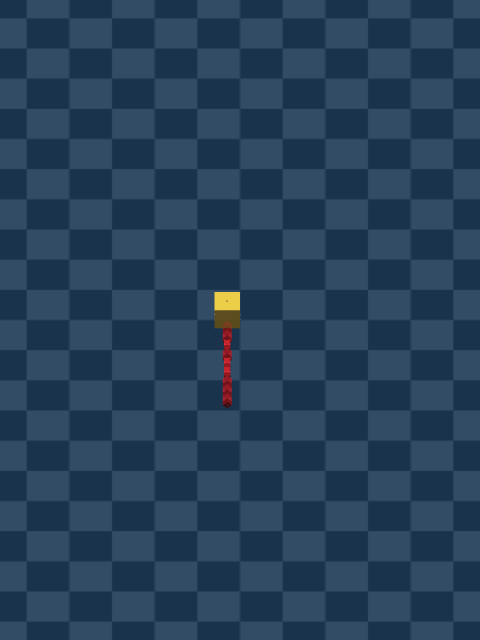

viewing: 897 with similarity [0.004999999888241291]

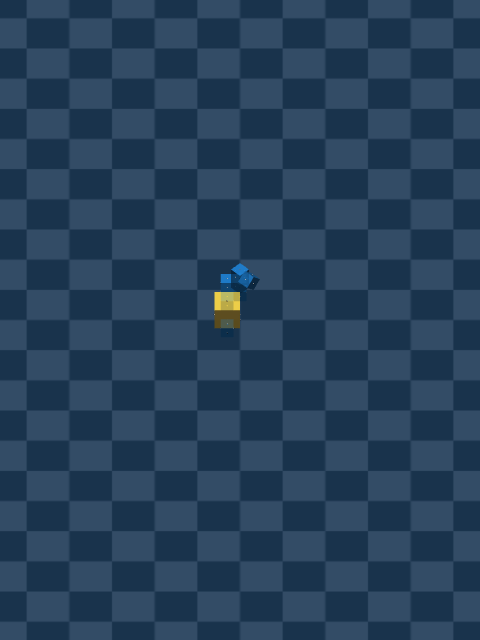

SimilarityResults(
    neighbourhood_dicts=(
        {
            0: ['C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'],
            1: ['C[r(H3)]', 'C[r(H3H)]', 'HHH1', 'HH1H3', 'HH3H3', 'HH3H', 'HHH3', 'HH3H2', 'HH2H', 'HH'],
            2: [
                'C[r(H3H)]',
                'C[r(H3HH1)]',
                'C[r(H3HH1H3)]',
                'HHH1H3H3',
                'HH1H3H3H',
                'HH3H3HH3',
                'HH3HH3H2',
                'HHH3H2H',
                'HH3H2H',
                'HH2H'
            ],
            3: [
                'C[r(H3HH1)]',
                'C[r(H3HH1H3)]',
                'C[r(H3HH1H3H3)]',
                'C[r(H3HH1H3H3H)]',
                'HHH1H3H3HH3',
                'HH1H3H3HH3H2',
                'HH3H3HH3H2H',
                'HH3HH3H2H',
                'HHH3H2H',
                'HH3H2H'
            ]
        },
        {
            0: ['C', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
            1: [
                'C[rl(B)]',
                'C[r(BB)]',
                'BB[rt(B)]',
                'B[l(B[r(B)b(B1)])]',
                'B[l(B)]',
                'B[r(B1)]',
                'B[r(B[b(B)])]',
                'B[r(B[l(B1)])]',
                'B[l(B1[t(B1)])]',
                'B[r(B1)]',
                'C[r(B)]'
            ],
            2: [
                'C[r(B)l(BB)]',
                'C[l(B)r(BB[rt(B)])]',
                'C[r(BB[r(B[l(B)t(B1)])t(B[r(B)])])]',
                'BB[t(B)r(B[l(B)t(B1)])]',
                'B[l(B[r(B)b(B1)])]',
                'B[l(B[r(B)b(B1)])]',
                'BB[r(B)t(B[r(B[l(B1)])])]',
                'B[r(B[b(B[b(B1[r(B1)])])])]',
                'B[r(B[l(B1[t(B1)])])]',
                'B[l(B1[t(B1)])]',
                'C[rl(B)]'
            ],
            3: [
                'C[l(B)r(BB[rt(B)])]',
                'C[l(B)r(BB[r(B[l(B)t(B1)])t(B[r(B)])])]',
                'C[l(B)r(BB[r(B[l(B)t(B1)])t(B[r(B[l(B1)])])])]',
                'C[r(BB[r(B[l(B)t(B1)])t(B[r(B)])])]',
                'BB[t(B)r(B[l(B)t(B1)])]',
                'BB[t(B)r(B[l(B)t(B1)])]',
                'C[r(BB[r(B[l(B)t(B1)])t(B[r(B[l(B1[t(B1)])])])])]',
                'BB[r(B)t(B[r(B[l(B1[t(B1)])])])]',
                'B[r(B[b(B[b(B1[r(B1)])])])]',
                'B[l(B[r(B1[b(B1)])])]',
                'C[l(B)r(BB)]'
            ]
        }
    ),
    similarity_value=0.005,
    tanimoto_dict={0: 0.05, 1: 0.0, 2: 0.0, 3: 0.0},
    selected_radii=[0, 1, 2, 3],
    obtained_weights=[1.0, 2.0, 3.0, 4.0]
)

In [15]:
node1 = ctk.from_graph(population[bottom[int(iterator)][0]]).canonicalize()
node2 = ctk.from_graph(population[bottom[int(iterator)][1]]).canonicalize()

console.print(f"viewing: {bottom[int(iterator)][0]} with similarity {[bottom[int(iterator)][2]]}")
view(node1.to_graph())
console.print(f"viewing: {bottom[int(iterator)][1]} with similarity {[bottom[int(iterator)][2]]}")
view(node2.to_graph())

results = ctk.calculate_similarity(node1, node2, config=similarity_config, return_all=True)
console.print(results)

iterator += 1 % N

-----

##### Interactive heatmap

In [16]:
fig = go.Figure(data=go.Heatmap(
    z=matrix,
    colorscale='Viridis',
    hovertemplate='Row: %{y}<br>Col: %{x}<br>Value: %{z:.3f}<extra></extra>'
))

fig.update_layout(
    title='Interactive Heatmap',
    xaxis_title='Column',
    yaxis_title='Row'
)
fig.show()


-----

##### Gui for just data

In [17]:
simple_navigator = SimpleNavigator(analyzed_population.to_dict())

----

##### Watch Robots

In [18]:
individual_visualizer = IndividualVisualizer(index_dict=analyzed_population.derived, population=population)

-----

##### See graphs

In [19]:
individual_visualizer = IndividualVisualizer(index_dict=analyzed_population.derived, population=population, visualize_fn=visualize_tree_from_graph)